In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt



In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 15
TRAIN_DIR = '/content/drive/MyDrive/DataSet/train'
VALIDATION_DIR = '/content/drive/MyDrive/DataSet/valid'
TEST_DIR = '/content/drive/MyDrive/DataSet/test'
CLASSES = [
    'Green Light', 'Red Light',
    'Speed Limit 10', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40',
    'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80',
    'Speed Limit 90', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120',
    'Stop'
]

In [5]:
def load_darknet_data(image_dir, label_dir, image_size, num_classes):
    images = []
    labels = []
    for image_path in Path(image_dir).glob("*.jpg"):  # Adjust the extension if needed
        label_path = label_dir / (image_path.stem + ".txt")
        # Load image
        img = tf.keras.utils.load_img(image_path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize
        # Load label
        if label_path.exists():
            with open(label_path, "r") as f:
                line = f.readline()
                format_line = line.strip().split()
                if (len(format_line)<1):
                  print("Problem in file : " + str(label_path))
                  continue
                class_id = line.strip().split()[0]
                label = to_categorical(int(class_id), num_classes)
        else:
            raise FileNotFoundError(f"Label file not found for {image_path}")

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
TRAIN_IMAGE_DIR = Path(TRAIN_DIR) / "images"
TRAIN_LABEL_DIR = Path(TRAIN_DIR) / "labels"
VALID_IMAGE_DIR = Path(VALIDATION_DIR) / "images"
VALID_LABEL_DIR = Path(VALIDATION_DIR) / "labels"

# Load datasets
train_images, train_labels = load_darknet_data(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES)
valid_images, valid_labels = load_darknet_data(VALID_IMAGE_DIR, VALID_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES)


Problem in file : /content/drive/MyDrive/DataSet/train/labels/FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt
Problem in file : /content/drive/MyDrive/DataSet/train/labels/FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt
Problem in file : /content/drive/MyDrive/DataSet/train/labels/FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt


In [7]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Step 2: Train the Model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset
)

Found 3530 images belonging to 2 classes.
Found 801 images belonging to 2 classes.
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.1431 - loss: 2.8961 - val_accuracy: 0.3196 - val_loss: 2.0326
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - accuracy: 0.3097 - loss: 2.1137 - val_accuracy: 0.3558 - val_loss: 1.9451
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.3504 - loss: 1.9572 - val_accuracy: 0.3708 - val_loss: 1.8853
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.4505 - loss: 1.7169 - val_accuracy: 0.4732 - val_loss: 1.5658
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.5315 - loss: 1.3963 - val_accuracy: 0.5318 - val_loss: 1.4754
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.5967 - loss: 1.1852 - val_accuracy: 0.5618 - val_loss: 1.4213
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.6818 - loss: 0.9257 - val_accuracy: 0.5643 - val_loss: 1.4382
Epoch 8/10
111

In [10]:
TEST_IMAGE_DIR = Path(TEST_DIR) / "images"
TEST_LABEL_DIR = Path(TEST_DIR) / "labels"

test_images, test_labels = load_darknet_data(TEST_IMAGE_DIR, TEST_LABEL_DIR, IMAGE_SIZE, NUM_CLASSES)

# Convert to TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

# Predict
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes)
print(confusion_mtx)

Problem in file : /content/drive/MyDrive/DataSet/test/labels/FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.txt
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 953ms/step
tf.Tensor(
[[48  4  0  0  4  0  0  1  1  1  1  4  5  0  0]
 [12 30  0  1  2  0  0  3  4  1  0  0  2  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 5  0  0 24  0  1  0  3  4  1  1  0  2  0  0]
 [ 1  0  0  1  9  1  0  3  0  0  1  2  1  0  1]
 [ 3  1  0  3  2 18  0  1  2  0  2  2  1  0  0]
 [ 1  0  0  0  0  0 42  0  0  0  0  0  0  1  0]
 [ 1  0  0  2  0  0  0 43  3  0  2  3  2  0  0]
 [ 2  2  0  5  0  0  0  7 15  0  0  4  9  3  0]
 [ 0  1  0  4  0  1  0  8  3 20  0  2  5  0  1]
 [ 1  1  0  2  0  0  0  2  0  3 27  2  4  0  1]
 [ 2  1  0  3  0  0  0  3  0  2  1 31  1  2  1]
 [ 2  1  0  6  1  1  0  6  3  0  3  0 29  2  1]
 [ 2  1  0  8  0  1  0  2  2  1  0  0  6  6  1]
 [ 2  0  0  0  0  0  0  1  0  0  1  1  2  3 37]], shape=(15, 15), dtype=int32)


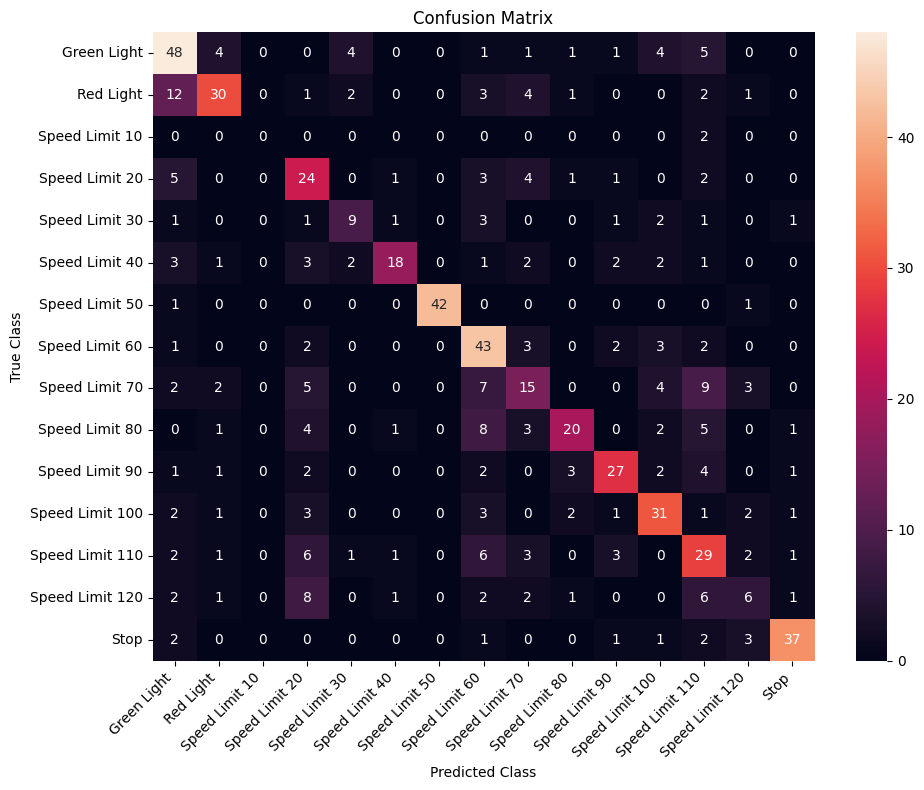

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming CLASSES is the list of class names
CLASS_NAMES = CLASSES

# Compute confusion matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes).numpy()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='rocket', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)              # Keep y-axis labels horizontal
plt.tight_layout()
plt.show()

In [15]:
# Sauvegarde du modèle
model.save('traffic_signs.keras')


In [23]:
from tensorflow.keras.utils import load_img, img_to_array
def classify_single_image(image_path, model, class_names, image_size):
    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)  # Resize image to match model's input
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_class_idx]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

image_path = "/content/red_light_test.jpg"
predicted_class = classify_single_image(image_path, model, CLASSES, IMAGE_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: Speed Limit 20
